# City Data Hack Challenge 2 – Social Isolation
 

This notebook demonstrates the use of the Python recipe wrapper to create a basic data pack that you can use to get you started with the challenge of Social Isolation for Barking and Dagenham borough. If you want to know more on the Challenge you can visit our [Tombolo website](http://www.tombolo.org.uk/challenge-2-social-isolation/). Don't forget that you can use the [City Data Explorer](https://tombolo-staging.emu-analytics.net) web app to visualise and style your results.



## Some Background

**The Tombolo project** is a Future Cities Catapult project funded by InnovateUK. It is a research and development project focused on understanding the value of data to unlock the potential of our cities. A big part of the Tombolo project is  the [Digital Connector](http://www.tombolo.org.uk/products/), an open source piece of software for Data Scientists to import and combine datasets into a standard format and model. You can visit the project on [Github](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector) to learn some background as well as instructions on how to use it.





## The goal

We will use the Python recipe implementation to tell Digital Connector to fetch some Social Isolation data for Barking and dagenham.

The geographical unit of measurement for our exports (the ***Subject*** in DC language) will be the Local Super Output Area (LSOA).

The data that we will be fetching are:
* Census data on disability
* Census data on widowed households
* Census data on elderly population
* DCLG data on households with children at risk of deprivation
* Data related to our [Social Infrastructure Index](https://github.com/FutureCitiesCatapult/digital-connector-python/blob/master/Samples/london-social-infrastructure.ipynb)
* Age UK loneliness data
* Census data on household with one inhabitant

**Please note that the above datasources are only indicative! You should think more holistic in order to tackle this challenge!**

Our output will be a GeoJson file conatining B&D's LSOAs along with the attributes of interest. Feel free to play around with the code, explore the DC and download more resources that will help you tackle the Challenge!

### Lets get started

First, we import some libraries that we will be using as well as the recipe.py file
that contains all the classes necessary to build our recipes

In [211]:
import geopandas as gpd
import os
from pathlib import Path
from matplotlib import pyplot as plt

home_dir = str(Path.home())

%matplotlib inline
%run os.path.join(home_dir, 'Desktop/python_library_dc/digital-connector-python/recipe.py')
dc_dir = '/Desktop/TomboloDigitalConnector'


The first thing we need to do is to create a **Subject**. This represents the core geometry on which all our operations will be based on. It also specifies the export geometry of our final geojson file. We are using *lsoa* and a **match_rule** to filter out all lsoa's not belonging to B&D borough.

Since we will be using OpenStreetMap data for the social isolation index, we will need to create another Subject. This is because OSM data have no common spatial reference with the main subject.

In [187]:
### recipe's subject
subject = Subject(subject_type_label='lsoa',provider_label='uk.gov.ons',
                  match_rule=Match_Rule(attribute_to_match_on='name', pattern='Barking%'))

subject_osm = Subject(subject_type_label='OSMEntity',provider_label='org.openstreetmap')

Next, we need to define our **Datasource**. This will tell DC what data to download. For more information on DC importers and datasource_id's consult the [catalogue.json](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector/blob/master/src/main/resources/catalogue.json) or use the terminal 

**gradle info -Pi= *name_of_the_class***

In [188]:
### recipe's datasources

lsoa = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter',
                            datasource_id='lsoa')

population_density = Datasource(importer_class='uk.org.tombolo.importer.ons.CensusImporter',
                            datasource_id='qs102ew')

households_composition = Datasource(importer_class='uk.org.tombolo.importer.ons.CensusImporter',
                            datasource_id='qs117ew')

widowed = Datasource(importer_class='uk.org.tombolo.importer.ons.CensusImporter',
                        datasource_id='qs108ew')

long_term_disability = Datasource(importer_class='uk.org.tombolo.importer.ons.CensusImporter',
                            datasource_id='qs303ew')

age_by_single_year = Datasource(importer_class='uk.org.tombolo.importer.ons.CensusImporter',
                            datasource_id='qs103ew')

imd = Datasource(importer_class='uk.org.tombolo.importer.dclg.IMDImporter',
                datasource_id='imd')

ageuk_loneliness = Datasource(importer_class='uk.org.tombolo.importer.londondatastore.LondonLonelinessImporter',
                              geography_scope= ['lsoa'],
                              datasource_id='lonelinessPrevalence')

osm_health = Datasource(importer_class='uk.org.tombolo.importer.osm.OSMImporter',
                       geography_scope = ['europe/great-britain/england/greater-london'],
                       datasource_id = 'OSMHealth')

osm_education = Datasource(importer_class='uk.org.tombolo.importer.osm.OSMImporter',
                       geography_scope = ['europe/great-britain/england/greater-london'],
                       datasource_id = 'OSMEducation')

osm_civic = Datasource(importer_class='uk.org.tombolo.importer.osm.OSMImporter',
                       geography_scope = ['europe/great-britain/england/greater-london'],
                       datasource_id = 'OSMCivic')


Now that we defined the datasources we need to tell the DC which attributes to fetch from the database. To do that we create **AttributeMatcher** fields for all the attributes of interest. 

In [189]:
### psql attributes

# We will be using population density to normalise our census data
population_density_a = AttributeMatcher(label='Area/Population Density: Density (number of persons per hectare)',
                                       provider = 'uk.gov.ons')

disability_a = AttributeMatcher(label='Disability: Day-to-day activities limited a lot',
                             provider = 'uk.gov.ons')

household_composition_a = AttributeMatcher(label='Adults in Household: 1 adult in household',
                                           provider  = 'uk.gov.ons')

ageuk_loneliness_a = AttributeMatcher(label='londonDecile',
                                      provider  = 'uk.gov.london')

# Here we are creating a list comprehension that will create AttributeMatcher fields for all ages over 65 years old.
# This is because census data on Age come as per individual year
ages_over_65_a = [AttributeMatcher(label='Age: Age %s'% age, provider  = 'uk.gov.ons') for age in range(65,99)]

widowed_a  = AttributeMatcher(label = 'Living Arrangement: Not living in a couple: Widowed or surviving partner from a same-sex civil partnership',
                             provider = 'uk.gov.ons')

imd_a  = AttributeMatcher(label = 'idaci_score',
                             provider = 'uk.gov.dclg')

# Notice that here we used another field called AttributeMatcherField to wrap AttributeMatcher. This is because 
# OSM data come as individual categories with no numerical values. We need to assign a constant value using 
# a ConstantField so we can perform operations such as summing.
health_count_a = AttributeMatcherField(field=ConstantField(value="1"),
                                        attributes=[AttributeMatcher(provider='org.openstreetmap',
                                                                     label='amenity',
                                                                     values= ["clinic",
                                                                              "dentist",
                                                                              "doctors",
                                                                              "hospital",
                                                                              "pharmacy"])],
                                        label='amenity')

education_count_a = AttributeMatcherField(field=ConstantField(value="1"),
                                        attributes=[AttributeMatcher(provider='org.openstreetmap',
                                                                     label='amenity',
                                                                     values= ["school",
                                                                              "library",
                                                                              "university",
                                                                              "college",
                                                                              "kindergarten"])],
                                        label='amenity')

civic_count_a = AttributeMatcherField(field=ConstantField(value="1"),
                                        attributes=[AttributeMatcher(provider='org.openstreetmap',
                                                                     label='amenity',
                                                                     values= ["courthouse",
                                                                              "coworking_space",
                                                                              "recycling",
                                                                              "fire_station",
                                                                              "place_of_worship",
                                                                              "police",
                                                                              "post_office",
                                                                              "town_hall",
                                                                              "waste_disposal"])],
                                        label='amenity')

Having specified the attributes that we will be using, we now need to use them within DC's **Fields**. There are numerous fields each one with its own unique properties. Please consult [DC's github repo](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector/blob/master/documentation/fields-and-models.md) for more information on fields.

In [190]:
### DC fields

# A very basic field that can handle numeric and time series attributes is LatestValueField. This essentially
# fetches the latest value within a time series if a time series exists. If not, it will just fetch teh default value.
population_density_f = LatestValueField(attribute_matcher=population_density_a,
                                                  label='Area/Population Density: Density (number of persons per hectare)')

disability_f = LatestValueField(attribute_matcher=disability_a,
                                                  label='Disability: Day-to-day activities limited a lot')

household_composition_f = LatestValueField(attribute_matcher=household_composition_a,
                                                  label='Adults in Household: 1 adult in household')

ages_over_65_f = [LatestValueField(attribute_matcher=i,
                                                  label='ages') for i in ages_over_65_a]

widowed_f = LatestValueField(attribute_matcher = widowed_a, 
                            label = 'Living Arrangement: Not living in a couple: Widowed or surviving partner from a same-sex civil partnership')

imd_f = LatestValueField(attribute_matcher=imd_a,
                         label='Income Deprivation Affecting Children Index (IDACI) Score (rate)')



For the OSM data, we will use a **GeographicAggregationField** to sum the individual amenities tha fall within each local authority. This way we will get an idea of how well a particular LSAO is served by different social amenities.

In [191]:
health_count_g = GeographicAggregationField(field=health_count_a,
                                            function = 'sum',
                                            subject=subject_osm,
                                            label = 'Health related amenities')

education_count_g = GeographicAggregationField(field=education_count_a,
                                            function = 'sum',
                                            subject=subject_osm,
                                            label = 'Education related amenities')

civic_count_g = GeographicAggregationField(field=civic_count_a,
                                            function = 'sum',
                                            subject=subject_osm,
                                            label = 'Civil infrastructure related amenities')


Now we need to normalise the census data by each LSOA's population desity. We will use the **ArithmeticField** for this task.

In [192]:
# Normalised census data
norm_disability = ArithmeticField(operation='div',
                                  operation_on_field_1 = disability_f,
                                  operation_on_field_2 = population_density_f,
                                  label = 'Norm. Disability: Day-to-day activities limited a lot')

norm_household_composition = ArithmeticField(operation = 'div',
                                  operation_on_field_1 = household_composition_f,
                                  operation_on_field_2 = population_density_f,
                                  label = 'Norm. Adults in Household: 1 adult in household')

norm_widowed = ArithmeticField(operation = 'div',
                                  operation_on_field_1 = widowed_f,
                                  operation_on_field_2 = population_density_f,
                                  label = 'Norm. Widowed or surviving partner from a same-sex civil partnership ')

# Summing all ages over 65
norm_ages_over_65 = ArithmeticField(operation='div',
                                   operation_on_field_1 = ListArithmeticField(fields=ages_over_65_f,
                                                                           operation='sum',
                                                                           label='sum ages'),
                                   operation_on_field_2 = population_density_f,
                                   label = 'Norm. Elderly (age >65)')
# AgeUK data
ageuk_loneliness_f = LatestValueField(attribute_matcher=ageuk_loneliness_a,
                                      label='Age UK Loneliness London deciles (1=most lonely)')





Now we are in a good shape to run our recipe!

In [201]:
### running DC

# We create a Dataset object containing all the information needed to create a DC recipe file
dataset = Dataset(subjects=[subject],
                  fields=[norm_disability,
                          norm_household_composition,
                          norm_ages_over_65,
                          ageuk_loneliness_f,
                          norm_widowed,
                          imd_f,
                          health_count_g,
                          education_count_g,
                          civic_count_g],
                  datasources=[lsoa,
                               population_density,
                               widowed,
                               imd,
                               households_composition,
                               long_term_disability,
                               ageuk_loneliness,
                               age_by_single_year,
                               osm_health,
                               osm_education,
                               osm_civic])


recipe = Recipe(dataset,timestamp=False)
recipe.build_recipe(console_print=False)

# We pass everything to DC
recipe.run_recipe(tombolo_path=home_dir + dc_dir,
                  clear_database_cache=False,
                  output_path = home_dir + '/challenge1_starter.json')

b'Starting a Gradle Daemon (subsequent builds will be faster)\n'
b':compileJava UP-TO-DATE\n'
b':processResources UP-TO-DATE\n'
b':classes UP-TO-DATE\n'
b':runExportHelp UP-TO-DATE\n'
b':runExport\n'
b'2018-03-16 11:59:20.619 [main] WARN  n.s.e.config.ConfigurationFactory - No configuration found. Configuring ehcache from ehcache-failsafe.xml  found in the classpath: jar:file:/Users/tbantis/.gradle/caches/modules-2/files-2.1/net.sf.ehcache/ehcache/2.10.3/cf74f9a4a049f181833b147a1d9aa62159c9d01d/ehcache-2.10.3.jar!/ehcache-failsafe.xml\n'
b'2018-03-16 11:59:23.051 [main] INFO  uk.org.tombolo.AbstractRunner - Setting file download cache: /tmp\n'
b"2018-03-16 11:59:23.384 [main] INFO  org.ehcache.core.EhcacheManager - Cache 'fields' created in EhcacheManager.\n"
b'2018-03-16 11:59:23.799 [main] INFO  u.o.t.importer.AbstractImporter - Skipped importing uk.org.tombolo.importer.ons.OaImporter:lsoa as this import has been completed previously\n'
b'2018-03-16 11:59:23.833 [main] INFO  u.o.t.im

In [202]:
gdf = gpd.read_file(home_dir + '/challenge1_starter.json')
gdf.head()

,Norm. Adults in Household: 1 adult in household,Health related amenities,name,Norm. Disability: Day-to-day activities limited a lot,label,Age UK Loneliness London deciles (1=most lonely),Income Deprivation Affecting Children Index (IDACI) Score (rate),Norm. Widowed or surviving partner from a same-sex civil partnership,Civil infrastructure related amenities,Norm. Elderly (age >65),Education related amenities,geometry
0,0.903614,0.0,Barking and Dagenham 016A,0.757315,E01000006,2.0,0.156,0.447504,0.0,1.144578,0.0,"POLYGON ((0.0912 51.5391, 0.09329999999999999 ..."
1,3.654676,2.0,Barking and Dagenham 015A,1.107914,E01000007,1.0,0.380,0.431655,1.0,0.834532,0.0,"POLYGON ((0.07779999999999999 51.5428, 0.07969..."
2,2.541087,0.0,Barking and Dagenham 015B,0.986094,E01000008,5.0,0.368,0.341340,0.0,0.505689,0.0,"(POLYGON ((0.06859999999999999 51.5362, 0.0680..."
3,1.161616,0.0,Barking and Dagenham 016B,1.103896,E01000009,3.0,0.283,0.490620,1.0,1.305916,0.0,"POLYGON ((0.0824 51.5427, 0.0842 51.5418, 0.08..."
4,3.977695,8.0,Barking and Dagenham 015C,1.102850,E01000010,5.0,0.317,0.594796,7.0,1.040892,2.0,"POLYGON ((0.0775 51.5397, 0.0781 51.5393, 0.07..."


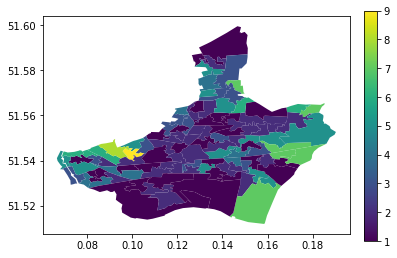

In [210]:
vmin=gdf['Age UK Loneliness London deciles (1=most lonely)'].min()
vmax=gdf['Age UK Loneliness London deciles (1=most lonely)'].max()
    
ax = gdf.plot(column='Age UK Loneliness London deciles (1=most lonely)', cmap='viridis',
              vmin=vmin,
              vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

